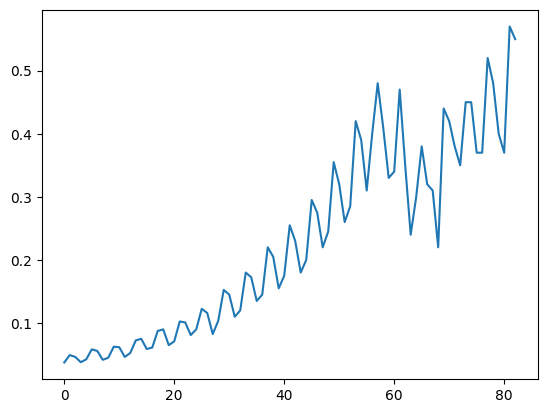

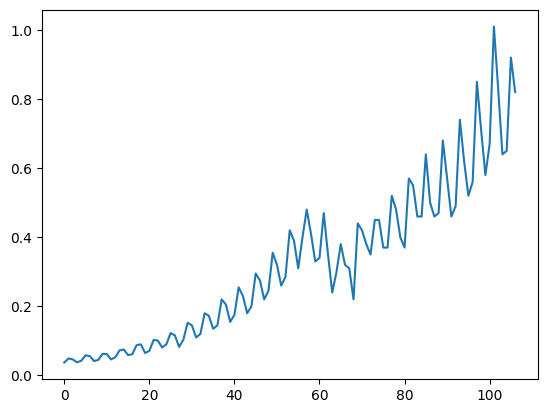

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

#datos = pd.read_csv('session8Data.csv', sep=";",decimal=",")
datos = pd.read_csv('../coca_cola_earnings.csv', sep=";",decimal=",")
y_full = datos.iloc[:,1]
y = datos.iloc[:,1][:-24]

plt.plot(y)
plt.show()
plt.plot(y_full)
plt.show()

In [39]:
# !pip install pmdarima

In [40]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 4
d = ndiffs(y_full, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y_full, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: 0.16109025294854745
p-value: 0.9699928584045158
Regular differences:  1
Seasonal differences: 1


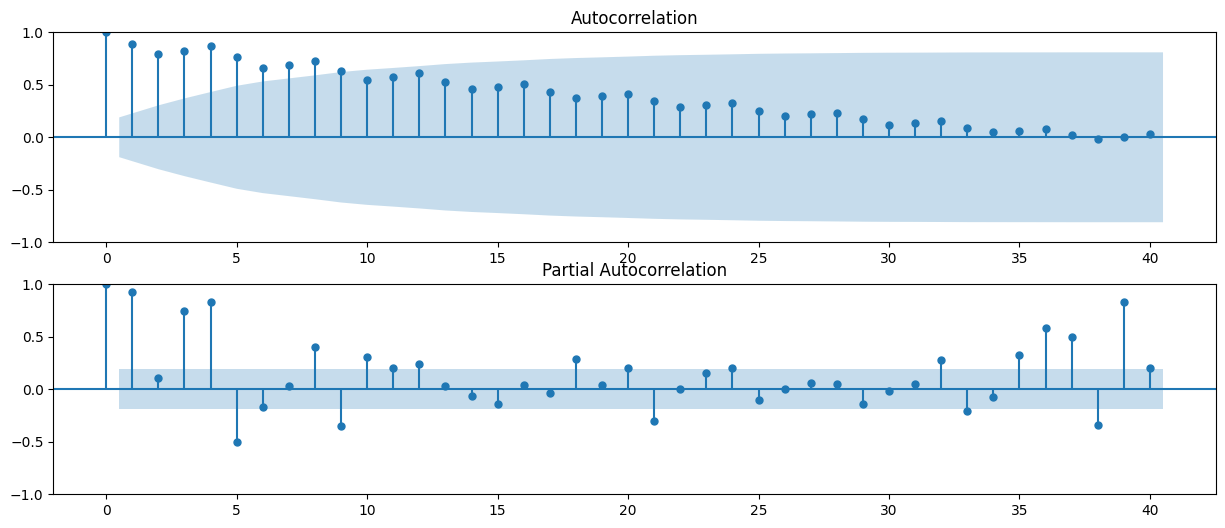

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 40 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y_full, lags = nlags, ax=ax[0])
plot_pacf(y_full, lags = nlags, method="ols", ax=ax[1])
plt.show()


                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  107
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 193.833
Date:                           Fri, 28 Oct 2022   AIC                           -381.665
Time:                                   20:24:25   BIC                           -373.790
Sample:                                        0   HQIC                          -378.476
                                           - 107                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1723      0.061     -2.834      0.005      -0.291      -0.053
ar.S.L4       -0.4388      0.089     -4.957

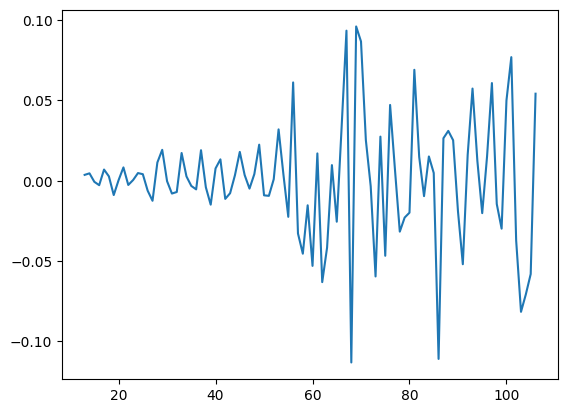

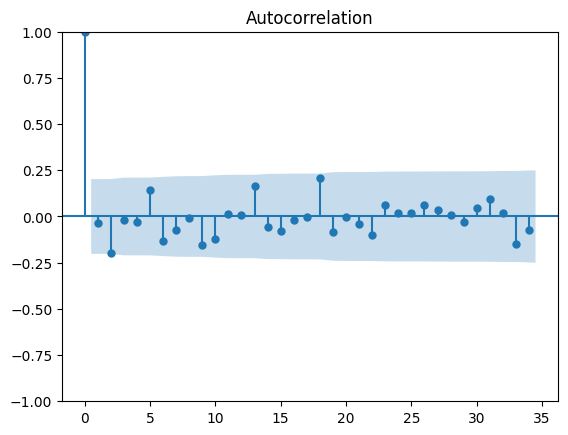

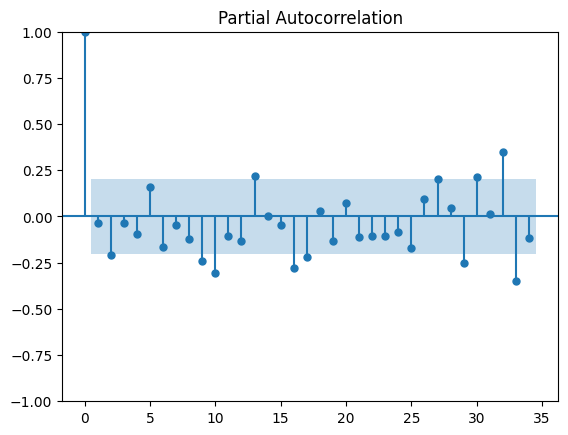

In [42]:
s = 4

#fit = SARIMAX(endog = y, order = (0,1,0), seasonal_order = (0,1,0,s)).fit()
fit = SARIMAX(endog = y, order = (1,1,0), seasonal_order = (1,1,0,s)).fit()
#fit = SARIMAX(endog = y, order = (0,1,1), seasonal_order = (0,1,1,s)).fit()

fit_full = SARIMAX(endog = y_full, order = (1,1,0), seasonal_order = (1,1,0,s)).fit()


# Jaime's
#fit = SARIMAX(endog = y, order = (2,2,0), seasonal_order = (1,0,1,s)).fit()
#fit = SARIMAX(endog = y, order = (0,2,2), seasonal_order = (1,0,0,s)).fit()

#fit_full = SARIMAX(endog = y_full, order = (0,2,2), seasonal_order = (1,0,0,s)).fit()

print(fit_full.summary())
residuos = fit_full.resid[13:]

nlags=34

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
plt.show()

In [43]:
d = ndiffs(residuos, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(residuos, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

Regular differences:  0
Seasonal differences: 0


Ljung-Box: Statistic value 32.59802835960551 p-value 0.6311865173757789
Shapido: Statistic value 0.9576229453086853 p-value 0.003965415060520172


C:\Users\artur\.conda\envs\mbd\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


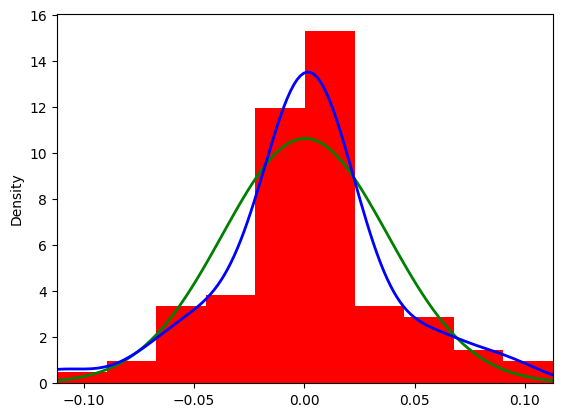

In [44]:
# Box test
import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[36])

print("Ljung-Box: Statistic value", box_test.iloc[0,0], "p-value", box_test.iloc[0,1]) 

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -3*sigma, mu +3*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 3*std, mean + 3*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 3*std, mean + 3*std)

plt.show()

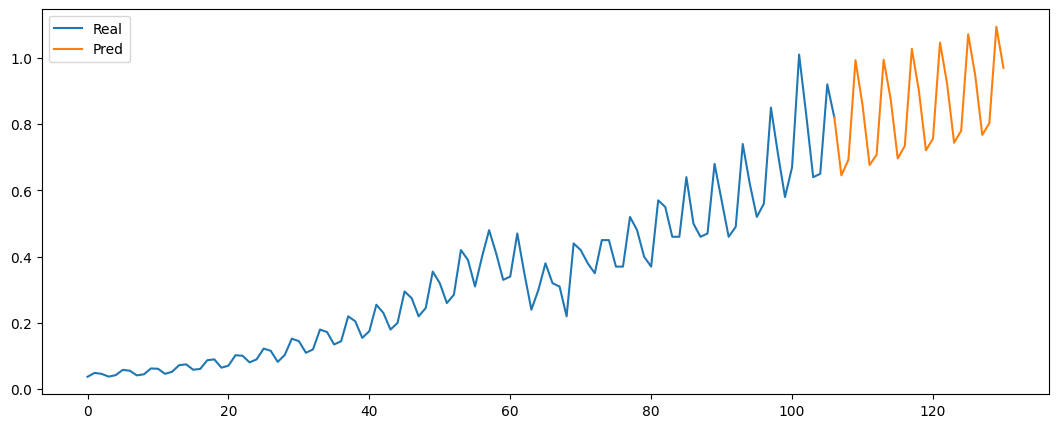

In [45]:
# Pintamos las siguientes 24 predicciones
y_pred = fit_full.forecast(steps = 24)

# Ponemos el último índice real
y_pred.loc[len(y_full)-1] = y_full[len(y_full)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y_full, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                   83
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 159.381
Date:                           Fri, 28 Oct 2022   AIC                           -312.761
Time:                                   20:24:26   BIC                           -305.691
Sample:                                        0   HQIC                          -309.931
                                            - 83                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3099      0.053     -5.802      0.000      -0.415      -0.205
ar.S.L4       -0.4321      0.083     -5.219

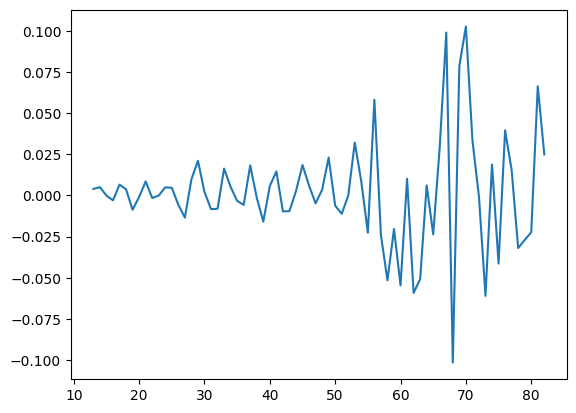

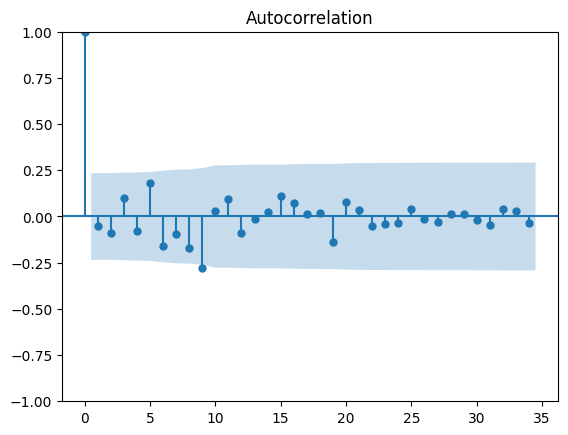

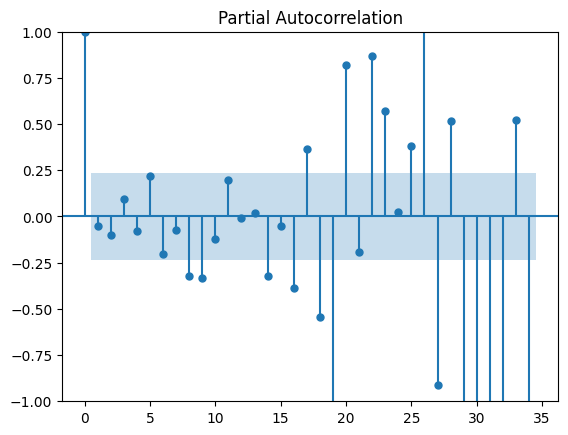

In [46]:
#s = 4

#fit = SARIMAX(endog = y, order = (0,1,0), seasonal_order = (0,1,0,s)).fit()
#fit = SARIMAX(endog = y, order = (1,1,0), seasonal_order = (1,1,0,s)).fit()
#fit = SARIMAX(endog = y, order = (0,1,1), seasonal_order = (0,1,1,s)).fit()

#fit_full = SARIMAX(endog = y_full, order = (1,1,0), seasonal_order = (1,1,0,s)).fit()

# Jaime's
#fit = SARIMAX(endog = y, order = (2,2,0), seasonal_order = (1,0,1,s)).fit()
#fit = SARIMAX(endog = y, order = (0,2,2), seasonal_order = (1,0,0,s)).fit()

print(fit.summary())
residuos = fit.resid[13:]

nlags=34

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
plt.show()

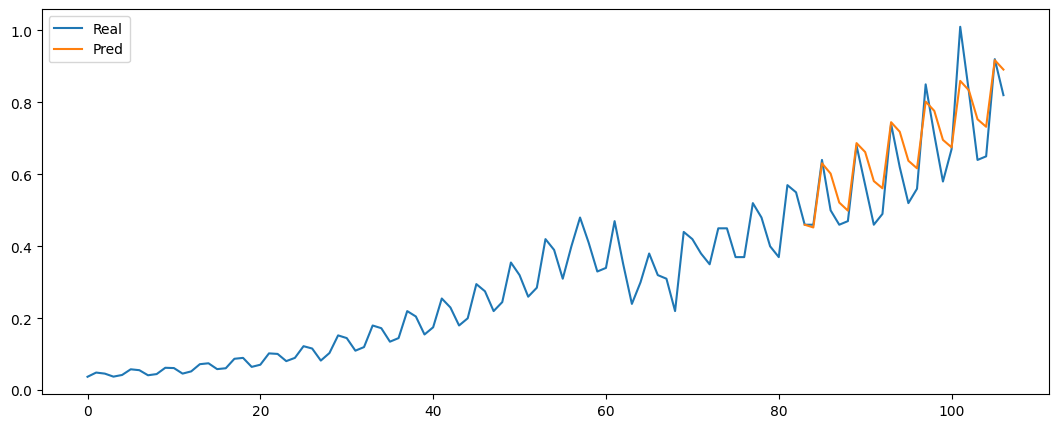

In [47]:
# Pintamos las siguientes 24 predicciones
y_pred = fit.forecast(steps = 24)

# Ponemos el último índice real
y_pred.loc[len(y_full)-24] = y_full[len(y_full)-24]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y_full, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

In [48]:
y_test = y_full[-24:].reset_index(drop=True)

In [49]:
y_eval = pd.Series(y_pred['predicted_mean']).reset_index(drop=True)

In [50]:
# Forecast Bias
forecast_errors = [y_test[i]-y_eval[i] for i in range(len(y_test))]
bias = sum(forecast_errors) * 1.0/len(y_test)

# MAE
mae = mean_absolute_error(y_test, y_eval)

# MSE
mse = mean_squared_error(y_test, y_eval)

# RMSE
rmse = sqrt(mse)

In [51]:
APE = []
  
# Iterate over the list values
for day in range(5):
  
    # Calculate percentage error
    per_err = (y_test[day] - y_eval[day]) / y_test[day]
  
    # Take absolute value of
    # the percentage error (APE)
    per_err = abs(per_err)
  
    # Append it to the APE list
    APE.append(per_err)
  
# Calculate the MAPE
MAPE = sum(APE)/len(APE)

In [52]:
print('ARIMA(1,1,0)x(1,1,0)s')
print('Bias: %f' % bias)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)
print(f'''MAPE   : { round(MAPE, 5) }
MAPE % : { round(MAPE*100, 5) } %
''')

ARIMA(1,1,0)x(1,1,0)s
Bias: -0.041693
MAE: 0.059861
MSE: 0.005732
RMSE: 0.075708
MAPE   : 0.07383
MAPE % : 7.38315 %

